In [25]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import pickle

In [2]:
train = pd.read_csv("../kaggle_data/train.csv")
test = pd.read_csv("../kaggle_data/test.csv")

In [3]:
train = train.loc[np.all(train.notna(), axis=1), :]
parentspecies_mapping = {
    'toluene': 1,
    'apin': 2,
    'decane': 3,
    'apin_toluene': 4,
    'apin_decane': 5,
    'apin_decane_toluene': 6,
    'decane_toluene': 7
}
train['parentspecies'] = train['parentspecies'].map(parentspecies_mapping)

In [5]:
train_x = train.loc[:, ~train.columns.isin(['log_pSat_Pa', 'ID'])]
train_y = train['log_pSat_Pa']

## Default model scores

In [13]:
dummy = DummyRegressor(strategy='mean')
dummy_scores = cross_val_score(dummy, train_x, train_y, cv=10, scoring='r2')

In [7]:
rf = RandomForestRegressor()
rf_scores = cross_val_score(rf, train_x, train_y, cv=10, scoring='r2')

In [8]:
svm_pipe = make_pipeline(StandardScaler(), SVR())
svm_scores = cross_val_score(svm_pipe, train_x, train_y, cv=10, scoring='r2')

In [9]:
gb = HistGradientBoostingRegressor()
gb_scores = cross_val_score(gb, train_x, train_y, cv=10, scoring='r2')

In [14]:
models = ['dummy', 'RF', 'SVR', 'GB']
scores = [np.mean(dummy_scores), np.mean(rf_scores), np.mean(svm_scores), np.mean(gb_scores)]
score_df = pd.DataFrame({'Models': models, 'Scores': scores})
print(score_df)

  Models    Scores
0  dummy -0.000264
1     RF  0.718509
2    SVR  0.743646
3     GB  0.742664


## Feature selection

### Random Forest

In [16]:
def select_only_important_features(
    feature_importances: pd.Series,
    rfr_model,
    X_train: pd.DataFrame,
    y_train: pd.DataFrame | np.ndarray,
):
    best_features = []
    r2_scores = []
    best_r2_score = 0
    
    for i in range(0, feature_importances.shape[0]):
        features = feature_importances.index[0:i+1].to_list()
        model = rfr_model.fit(X_train.loc[:, features], y_train)
        scores = cross_val_score(model, X_train.loc[:, features], y_train, cv=3, scoring='r2')
        mean_score = np.mean(scores)
        if mean_score > best_r2_score:
            best_features = features
            best_r2_score = mean_score
        r2_scores.append(mean_score)

    return best_features, r2_scores

In [ ]:
rf_fit = rf.fit(train_x, train_y)
rf_feature_importances = pd.Series(rf_fit.feature_importances_, index=train_x.columns)
rf_feature_importances = rf_feature_importances.sort_values(ascending=False)
rf_best_features, rf_r2_scores = select_only_important_features(rf_feature_importances, RandomForestRegressor(), train_x, train_y)

In [ ]:
print(rf_feature_importances)

NumHBondDonors                  0.471869
NumOfC                          0.120337
NumOfConf                       0.111384
NumOfConfUsed                   0.055185
NumOfAtoms                      0.053150
MW                              0.025172
hydroxyl (alkyl)                0.020183
carbonylperoxynitrate           0.019602
ketone                          0.017173
carboxylic acid                 0.016265
NumOfO                          0.013932
aldehyde                        0.012706
peroxide                        0.008625
hydroperoxide                   0.008464
carbonylperoxyacid              0.007830
C=C (non-aromatic)              0.007002
ester                           0.006881
parentspecies                   0.005245
ether (alicyclic)               0.005244
nitrate                         0.005078
nitro                           0.004382
NumOfN                          0.002678
nitroester                      0.000807
C=C-C=O in non-aromatic ring    0.000765
aromatic hydroxy

In [ ]:
print(sorted(rf_r2_scores, reverse=True))

[0.7157243501948923, 0.7152187064075247, 0.7150435832707971, 0.714897085943527, 0.7148061734374386, 0.7142495141060013, 0.7141501038246302, 0.7131486089611538, 0.7106337966426595, 0.7065363411211512, 0.7043889281302754, 0.702970930309411, 0.7011022523607435, 0.6952064309122724, 0.6933803086612133, 0.6931657467589214, 0.6851420066328263, 0.6718531556942233, 0.6629716126081987, 0.6327550448762516, 0.6285703051135717, 0.6085972432918004, 0.5607768777889884, 0.54370346450602, 0.4751318834471759]


Text(0, 0.5, 'R2')

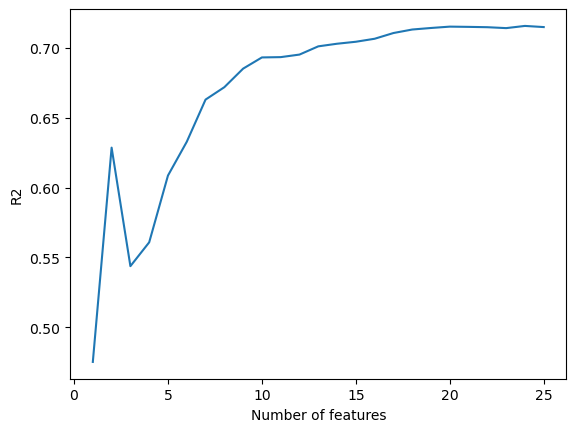

In [ ]:
plt.plot(np.arange(1,26), rf_r2_scores)
plt.xlabel('Number of features')
plt.ylabel('R2')
plt.title('R2 of RF with n most important features')
plt.show()

### Support Vector Regression

In [6]:
svm_pipe = make_pipeline(StandardScaler(), SVR())
svm_pipe.fit(train_x, train_y)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svr', SVR())])

In [ ]:
result = permutation_importance(svm_pipe, train_x, train_y, n_repeats=10, random_state=0)

In [20]:
svm_feature_importances = result.importances_mean
svm_feature_importances = pd.Series(svm_feature_importances, index=train_x.columns)
svm_feature_importances = svm_feature_importances.sort_values(ascending=False)
svm_best_features, svm_r2_scores = select_only_important_features(svm_feature_importances, make_pipeline(StandardScaler(), SVR()), train_x, train_y)

In [19]:
print(svm_feature_importances)

NumOfC                          0.342834
NumHBondDonors                  0.246036
NumOfConf                       0.121222
carboxylic acid                 0.099756
NumOfAtoms                      0.060547
hydroperoxide                   0.055878
carbonylperoxyacid              0.044974
peroxide                        0.044873
hydroxyl (alkyl)                0.037951
NumOfConfUsed                   0.032414
MW                              0.030140
carbonylperoxynitrate           0.028654
ketone                          0.027432
NumOfO                          0.025452
ether (alicyclic)               0.022740
parentspecies                   0.022603
C=C (non-aromatic)              0.020821
aldehyde                        0.014401
ester                           0.010083
nitrate                         0.009378
NumOfN                          0.009148
nitro                           0.007216
C=C-C=O in non-aromatic ring    0.005325
nitroester                      0.004249
aromatic hydroxy

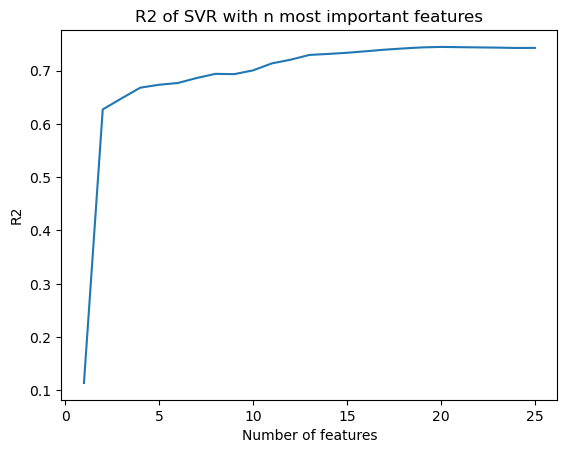

In [21]:
plt.plot(np.arange(1,26), svm_r2_scores)
plt.xlabel('Number of features')
plt.ylabel('R2')
plt.title('R2 of SVR with n most important features')
plt.show()

## Pickle some stuff

In [26]:
with open('pickles/svm_feature_importances.pickle', 'wb+') as handle:
    pickle.dump(result, handle, protocol=pickle.HIGHEST_PROTOCOL)